# Galaxy Image Classification 

### Importing Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm #displays progress bar within for loops
import matplotlib.pyplot as plt
from skimage import io
import pickle
from skimage.transform import resize
import glob
import os
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
from keras import regularizers, optimizers

from functions.model_functions import plot_confusion_matrix, predict_one_image_cnn

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


### Size of all images

```python
size = set()
for filename in glob.glob('data/*.jpg'): 
    im=io.imread(filename).shape
    size.add(im)``` 

size for all images are: {(424, 424, 3)}

### Visualizing some of the training data

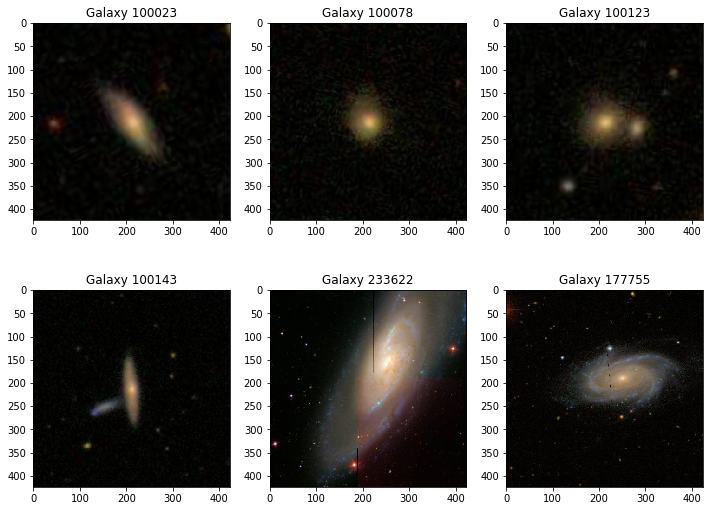

<Figure size 432x288 with 0 Axes>

In [2]:
#Let's look at four of our galaxies from the 61578 images in our training set. 

plt.figure(1, figsize=(12,9))
plt.subplot(231)
plt.imshow(plt.imread('data/train/spiral/100023.jpg'))
plt.title('Galaxy 100023')

plt.subplot(232)
plt.imshow(plt.imread('data/train/elliptical/100078.jpg'))
plt.title('Galaxy 100078')

plt.subplot(233)
plt.imshow(plt.imread('data/train/elliptical/100123.jpg'))
plt.title('Galaxy 100123')

plt.subplot(234)
plt.imshow(plt.imread('data/train/spiral/100143.jpg'))
plt.title('Galaxy 100143')

plt.subplot(235)
plt.imshow(plt.imread('data/train/spiral/233622.jpg'))
plt.title('Galaxy 233622')

plt.subplot(236)
plt.imshow(plt.imread('data/train/spiral/177755.jpg'))
plt.title('Galaxy 177755')

plt.show()
plt.tight_layout()

From the images above, as a scientist I can already tell what morphology these galaxies are of, but now the question is will the computer be able to classify them correctly. Let's first build a baseline model then compare it to a CNN model. 

### Predictions.csv

In [3]:
import pandas as pd
import numpy as np

predictions = pd.read_csv('predictions.csv')
predictions.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


There seems to be ambigious headings for our columns and the resources on Kaggle don't seem to help much. Essentially, the classes refer to the morphology on the galaxy. 

In [4]:
#All of the classes in our Class1 add up to 1. These classes refer to the probaility of 
#the galaxy being either the shape in Class1.1, Class1.2, or in Class1.3. 

(predictions['Class1.1'] + predictions['Class1.2'] + predictions['Class1.3']).head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [5]:
#Dropping all the other columns which do not refer to the morphology. 
predictions = predictions[['GalaxyID','Class1.1', 'Class1.2', 'Class1.3']]
predictions.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
5,100122,0.738832,0.238159,0.023009
6,100123,0.462492,0.456033,0.081475
7,100128,0.687783,0.288344,0.023873
8,100134,0.021834,0.976952,0.001214
9,100143,0.269843,0.730157,0.000000


Based on the images printed above, we can use our physics brain to determine what the columns stand for and rename the columns. 

In [6]:
predictions.columns = ['GalaxyID', 'Elliptical', 'Spiral', 'Irregular']
predictions.head()

,GalaxyID,Elliptical,Spiral,Irregular
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161


If the value in the irregular was the max value for that row, we called it an irregular. 

Note: The following code below no longer works because the irregular folders are deleted. 

```python
print('num in train elliptical = {}'.format(len(os.listdir('data/train/elliptical/'))))
print('num in train spiral = {}'.format(len(os.listdir('data/train/spiral/'))))
print('num in train irregular = {}'.format(len(os.listdir('data/train/irregular/'))))
print('num in test elliptical = {}'.format(len(os.listdir('data/test/elliptical/'))))
print('num in test spiral = {}'.format(len(os.listdir('data/test/spiral/'))))
print('num in test irregular = {}'.format(len(os.listdir('data/test/irregular/'))))```

num in train elliptical = 13237 <br>
num in train spiral = 17526 <br>
num in train irregular = 26 <br>
num in test elliptical = 13456 <br>
num in test spiral = 17300 <br>
num in test irregular = 33 <br>

For this, we can remove the irregular images since they make such a small portion of our over all dataset. 

Now, let's delete the irregular galaxies from the predictions (because we deleted their images). Then we will drop the "Irregular" column.

In [7]:
len(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)])

59

In [8]:
predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].head()

,GalaxyID,Elliptical,Spiral,Irregular
1791,126783,0.178000,0.044000,0.778000
2376,135453,0.360342,0.098619,0.541039
6957,202788,0.242413,0.290022,0.467565
7434,209411,0.273749,0.202910,0.523342
7557,211113,0.289000,0.133000,0.578000


In [9]:
#Dropped all the irregular galaxies. 
predictions.drop(predictions[(predictions.Irregular > predictions.Spiral) & (predictions.Irregular > predictions.Elliptical)].index,inplace=True)

In [10]:
predictions.drop(['Irregular'], axis=1, inplace=True)

In [11]:
predictions.head()

,GalaxyID,Elliptical,Spiral
0,100008,0.383147,0.616853
1,100023,0.327001,0.663777
2,100053,0.765717,0.177352
3,100078,0.693377,0.238564
4,100090,0.933839,0.000000


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from keras.layers import Dropout 
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [13]:
# get all the data in the directory split/test, and reshape them
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=90,
                            brightness_range=(0.5,2),
                            )

#Take 30000 images from the training folder and resize images down to 106 x 106 px
data_tr=datagen.flow_from_directory(
        'data/train', 
        target_size=(106, 106), #actual image size 
        batch_size = 30000,
        class_mode='binary',
        seed = 123)

Found 30763 images belonging to 2 classes.


In [14]:
#Take 20000 images from the testing folder and resize images down to 106 x 106 px
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        'data/test', 
        target_size=(106, 106), 
        batch_size = 20000, 
        class_mode='binary',
        seed = 123) 

Found 30756 images belonging to 2 classes.


In [15]:
# Defining x_train, y_train, and x_test, y_test by grabbing the first 30,000 batch for train 
# and 20,000 image batch for test

x_tr, y_tr = next(data_tr)
x_te, y_te = next(data_te)

In [16]:
#Displaying that our training data is binary

y_tr[:5]

array([1., 1., 0., 0., 1.], dtype=float32)

In [17]:
#Splitting our data using sklearn. 80% of our data is X_train, y_train - what we are training 
#our model on. 20% of our data is the X_val, y_val what we are testing our data on. 

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.20, random_state=123)


In [ ]:
len(x_te)

In [ ]:
X_val.shape

## CNN Architecture

In [63]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.1), input_shape=(106, 106, 3), padding='valid',strides=(2,2)))
cnn.add(layers.Conv2D(64, (3, 3), input_shape=(106, 106,  3), padding='valid',strides=(2,2)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(0.5))
cnn.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.1)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())

cnn.add(layers.Dense(128))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))

cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))        
        

# decay_rate = learning_rate / epochs
sgd = optimizers.SGD(lr=0.01, decay=0.0002, momentum=0.9, nesterov=False)
cnn.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['acc'])
    
cnn.load_weights('model_weights/cnn11_only_lr.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Fitting CNN Model

In [ ]:
cnn1 = cnn.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=500)

In [ ]:
print(cnn.summary())

## Let's see what our CNN is doing behind the scenes when it is fed this image:

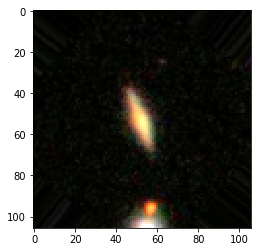

In [64]:
# Printing one random image to compare with the hidden layers below.

plt.imshow(X_train[1000])
plt.show()

## Grabbing the first hidden 8 layers from CNN to visualize the activation from the first layer

In [65]:
layer_outputs = [layer.output for layer in cnn.layers[:8]]

In [66]:
activation_model = models.Model(inputs=cnn.input, outputs=layer_outputs)

In [67]:
from keras import models

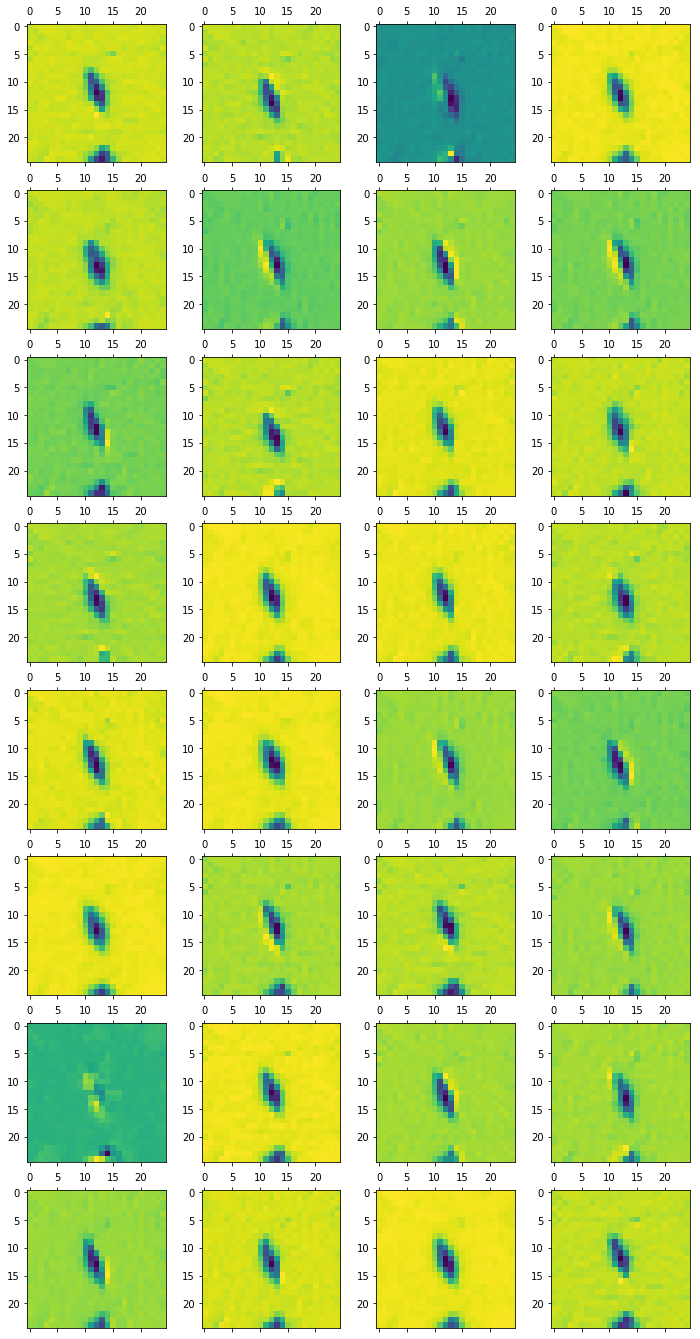

In [68]:
# from keras import models
from keras.preprocessing import image

activations = activation_model.predict(X_train)

fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[1]
    ax.matshow(first_layer_activation[1000, :, :, i], cmap='viridis') 

## Confusion Matrix for CNN

In [69]:
cnn.evaluate(x_te, y_te)

20000/20000 [==============================] - 29s 1ms/step


[0.521887234210968, 0.79075]

In [70]:
predictions_cnn = cnn.predict(x_te)
predictions_cnn = np.around(predictions_cnn)

In [71]:
f1_score(y_te, predictions_cnn, average='macro')

0.7873114379632022

Confusion matrix, without normalization
[[6636 2109]
 [2076 9179]]


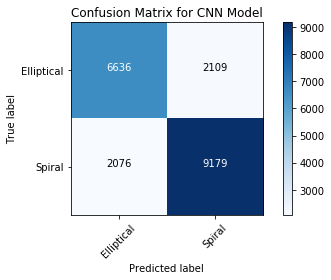

In [72]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_te, predictions_cnn), classes=['Elliptical', 'Spiral'])
plt.title('Confusion Matrix for CNN Model')
plt.savefig('CNN_ConfusionMatrix.png')


## Let's test our model on some images of galaxies it has not seen yet.

In [ ]:
def predictoneimage_cnn(cnn, path):
    img = load_img(path, target_size=(106, 106))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = cnn.predict(img)
    return predict 

#### Keras' flow_from_directory method orders folder structure alphabetical, elliptical is first, and 0 is first. So, 0 is elliptical and 1 is spiral. 

array([[0.29584587]], dtype=float32)

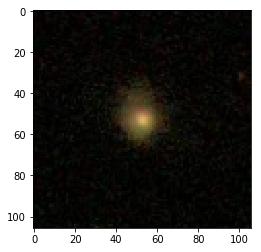

In [73]:
predict_one_image_cnn(cnn, 'data/train/elliptical/100078.jpg') 

array([[0.09924649]], dtype=float32)

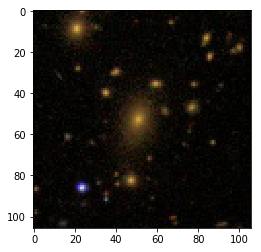

In [74]:
predict_one_image_cnn(cnn, 'data/test/elliptical/564639.jpg')

#### The CNN model classified the above galaxy as an elliptical. Which is correct since this test image came from the elliptical folder. 

## ROC Curve for CNN Model

In [75]:
from sklearn.metrics import roc_curve

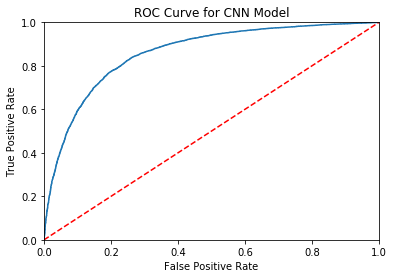

In [76]:
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_te, cnn.predict(x_te))

plt.plot(fpr_cnn,tpr_cnn)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for CNN Model')
# plt.show()
plt.savefig('CNN_ROC.png')

In [77]:
from sklearn.metrics import auc
roc_auc = auc(fpr_cnn, tpr_cnn)

In [78]:
print(roc_auc)

0.8601756871159988


# Decision Tree  

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_model = DecisionTreeClassifier(max_depth=10)  

In [19]:
x_tr.shape

(30000, 106, 106, 3)

In [20]:
X_train.shape

(24000, 106, 106, 3)

In [21]:
y_train.shape

(24000,)

In [22]:
x_tr_flat = X_train.reshape((24000,X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))

In [23]:
tree_model.fit(x_tr_flat, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
x_te.shape

(20000, 106, 106, 3)

In [25]:
x_te_flat = x_te.reshape((20000,x_te.shape[1]*x_te.shape[2]*x_te.shape[3]))

In [33]:
y_predict = tree_model.predict(x_te_flat)

In [27]:
y_predict_proba = tree_model.predict_proba(x_te_flat)

In [28]:
y_predict_proba

array([[0.91032609, 0.08967391],
       [0.03174603, 0.96825397],
       [0.10344828, 0.89655172],
       ...,
       [0.06465517, 0.93534483],
       [1.        , 0.        ],
       [0.015625  , 0.984375  ]])

In [34]:
accuracy_score(y_te, y_predict)

0.6887

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_predict)

array([[5899, 2846],
       [3380, 7875]])

Confusion matrix, without normalization
[[5899 2846]
 [3380 7875]]


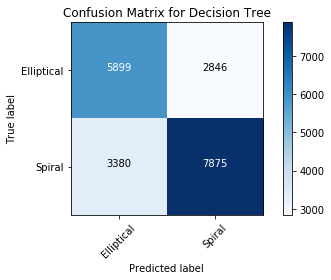

In [36]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_te, y_predict), classes=['Elliptical', 'Spiral'])
plt.title('Confusion Matrix for Decision Tree')
plt.savefig('DecisionTree_ConfusionMatrix.png')

In [51]:
y_te[:10]

array([0., 1., 1., 1., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [58]:
# np.unique(y_predict_proba)[:5]
y_predict_proba[:10]

array([[0.91032609, 0.08967391],
       [0.03174603, 0.96825397],
       [0.10344828, 0.89655172],
       [0.        , 1.        ],
       [0.07480315, 0.92519685],
       [0.07480315, 0.92519685],
       [0.10576923, 0.89423077],
       [0.        , 1.        ],
       [0.88823529, 0.11176471],
       [0.16923077, 0.83076923]])

In [59]:
[x[1] for x in y_predict_proba][:10]

[0.08967391304347826,
 0.9682539682539683,
 0.896551724137931,
 1.0,
 0.9251968503937008,
 0.9251968503937008,
 0.8942307692307693,
 1.0,
 0.11176470588235295,
 0.8307692307692308]

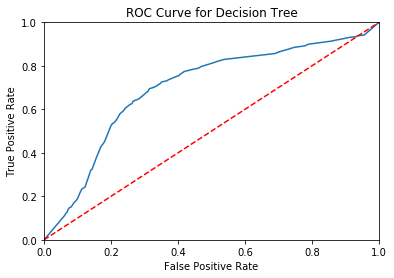

In [105]:
from sklearn.metrics import auc, roc_curve

fpr_decision, tpr_decision, thresholds = roc_curve(y_te, [x[1] for x in y_predict_proba])

plt.plot(fpr_decision,tpr_decision)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Decision Tree')
# plt.show()
plt.savefig('DecisionTree_ROC.png')

In [106]:
roc_auc = auc(fpr_decision, tpr_decision)

In [110]:
# fpr_decision

In [111]:
# tpr_decision

In [109]:
print(roc_auc)

0.6984602739294575


# Inception

In [79]:
#we can use any of the inception stuff even if they are trained on anything
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [80]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [81]:
for i,layer in enumerate(imagenet.layers):
    print(i,layer.name, layer.trainable)

0 input_1 False
1 conv2d_4 True
2 batch_normalization_4 True
3 activation_4 True
4 conv2d_5 True
5 batch_normalization_5 True
6 activation_5 True
7 conv2d_6 True
8 batch_normalization_6 True
9 activation_6 True
10 max_pooling2d_3 True
11 conv2d_7 True
12 batch_normalization_7 True
13 activation_7 True
14 conv2d_8 True
15 batch_normalization_8 True
16 activation_8 True
17 max_pooling2d_4 True
18 conv2d_12 True
19 batch_normalization_12 True
20 activation_12 True
21 conv2d_10 True
22 conv2d_13 True
23 batch_normalization_10 True
24 batch_normalization_13 True
25 activation_10 True
26 activation_13 True
27 average_pooling2d_1 True
28 conv2d_9 True
29 conv2d_11 True
30 conv2d_14 True
31 conv2d_15 True
32 batch_normalization_9 True
33 batch_normalization_11 True
34 batch_normalization_14 True
35 batch_normalization_15 True
36 activation_9 True
37 activation_11 True
38 activation_14 True
39 activation_15 True
40 mixed0 True
41 conv2d_19 True
42 batch_normalization_19 True
43 activation_19 Tr

In [82]:
#don't train the image net (or you will wait too long which is the first layer)
for layer in new_model.layers[:1]:
    layer.trainable=False

In [83]:

new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
new_model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 320s 13ms/step - loss: 0.6184 - acc: 0.6614 - val_loss: 0.8695 - val_acc: 0.5390
Epoch 2/10
24000/24000 [==============================] - 297s 12ms/step - loss: 0.5916 - acc: 0.6817 - val_loss: 0.7445 - val_acc: 0.5502
Epoch 3/10
24000/24000 [==============================] - 258s 11ms/step - loss: 0.5806 - acc: 0.6937 - val_loss: 0.6791 - val_acc: 0.6050
Epoch 4/10
24000/24000 [==============================] - 277s 12ms/step - loss: 0.5765 - acc: 0.6966 - val_loss: 0.7362 - val_acc: 0.5488
Epoch 5/10
24000/24000 [==============================] - 275s 11ms/step - loss: 0.5692 - acc: 0.7007 - val_loss: 1.1220 - val_acc: 0.5000
Epoch 6/10
24000/24000 [==============================] - 279s 12ms/step - loss: 0.5728 - acc: 0.6979 - val_loss: 0.8048 - val_acc: 0.5378
Epoch 7/10
24000/24000 [==============================] - 263s 11ms/s

In [84]:
new_model.evaluate(x_te, y_te)

20000/20000 [==============================] - 256s 13ms/step


[0.7556947304725647, 0.5354]

In [85]:
predictions_transfer = new_model.predict(x_te)
predictions_transfer = np.around(predictions_transfer)

In [86]:
f1_score(y_te, predictions_transfer, average='macro') 

0.5048216209418035

Confusion matrix, without normalization
[[7839  906]
 [8386 2869]]


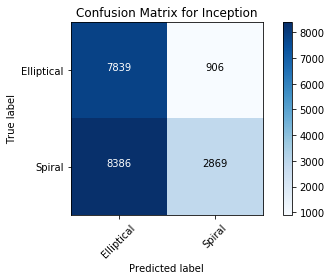

In [87]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_te, predictions_transfer), classes=['Elliptical', 'Spiral'])
plt.title('Confusion Matrix for Inception')
plt.savefig('Inception_ConfusionMatrix.png')


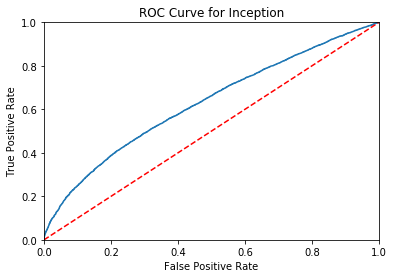

In [112]:
fpr_inception, tpr_inception, thresholds = roc_curve(y_te, new_model.predict(x_te))

plt.plot(fpr_inception,tpr_inception)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Inception')
plt.savefig('Inception_ROC.png')
# plt.show()

### Simple Neural Network Baseline Model

In [89]:
from keras.models import Sequential, Input
from keras.layers import Dense
model = Sequential()

In [90]:
model.add(layers.Flatten(input_shape=(106, 106,  3)))
layer_1 = model.add(Dense(units=128, activation='relu')) 
layer_2 = model.add(Dense(units=1, activation='sigmoid'))

In [91]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [92]:
history = model.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=500)

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 7s 274us/step - loss: 0.6586 - acc: 0.6196 - val_loss: 0.6371 - val_acc: 0.6652
Epoch 2/50
24000/24000 [==============================] - 5s 193us/step - loss: 0.6281 - acc: 0.6750 - val_loss: 0.6176 - val_acc: 0.6927
Epoch 3/50
24000/24000 [==============================] - 5s 195us/step - loss: 0.6134 - acc: 0.6923 - val_loss: 0.6077 - val_acc: 0.6958
Epoch 4/50
24000/24000 [==============================] - 5s 196us/step - loss: 0.6057 - acc: 0.7022 - val_loss: 0.6008 - val_acc: 0.7102
Epoch 5/50
24000/24000 [==============================] - 5s 191us/step - loss: 0.5996 - acc: 0.7071 - val_loss: 0.5966 - val_acc: 0.7205
Epoch 6/50
24000/24000 [==============================] - 5s 190us/step - loss: 0.5956 - acc: 0.7101 - val_loss: 0.5919 - val_acc: 0.7177
Epoch 7/50
24000/24000 [==============================] - 5s 188us/step - loss: 0.5913 - acc: 0.7162 - val_loss: 0.5901 - v

In [93]:
# history.history['val_acc'] 


In [94]:
predictions_mlp = model.predict(x_te)
predictions_mlp = np.around(predictions_mlp)

Confusion matrix, without normalization
[[5882 2863]
 [1612 9643]]


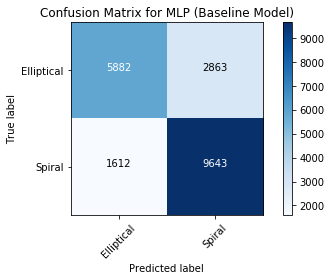

In [95]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_te, predictions_mlp), classes=['Elliptical', 'Spiral'])
plt.title('Confusion Matrix for MLP (Baseline Model)')
plt.savefig('Baseline_MLP_ConfusionMatrix.png')


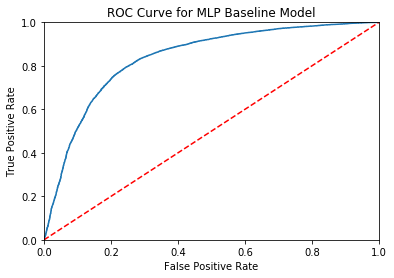

In [96]:
fpr_neural, tpr_neural, thresholds = roc_curve(y_te, model.predict(x_te))

plt.plot(fpr_neural,tpr_neural)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for MLP Baseline Model')
plt.savefig('BaselineMLP_ROC.png')

In [97]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99736993, 0.99736993,
       1.        ])

In [98]:
tpr

array([0.00000000e+00, 8.88494003e-05, 1.77698801e-04, ...,
       9.99911151e-01, 1.00000000e+00, 1.00000000e+00])

Text(0, 0.5, 'Validation Accuracy')

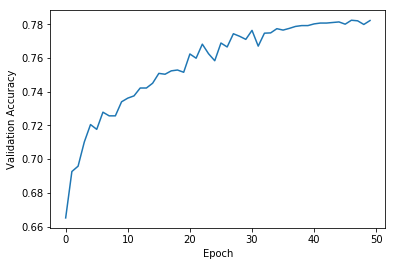

In [99]:
plt.figure()
plt.plot(range(len(history.history['val_acc'])), history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

In [100]:
loss_and_metrics = model.evaluate(x_te, y_te)

20000/20000 [==============================] - 3s 129us/step


In [101]:
loss_and_metrics

[0.526056180858612, 0.77625]

In [102]:
model.metrics_names

['loss', 'acc']

In [103]:
model.save('simple_nn_baseline.h5')

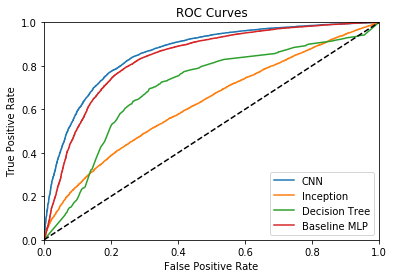

In [113]:
# fpr_cnn, tpr_cnn, thresholds = roc_curve(y_te, cnn.predict(x_te)) # CNN -- already have
fpr_decision, tpr_decision, thresholds = roc_curve(y_te, [x[1] for x in y_predict_proba])
# fpr, tpr, thresholds = roc_curve(y_te, new_model.predict(x_te)) # inception
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_te, model.predict(x_te)) # simple MLP

plt.plot(fpr_cnn, tpr_cnn, label='CNN')
plt.plot(fpr_inception, tpr_inception, label='Inception')
plt.plot(fpr_decision, tpr_decision, label="Decision Tree")
plt.plot(fpr_mlp, tpr_mlp, label="Baseline MLP")

plt.plot([0, 1], [0, 1],linestyle='--',c='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.savefig('all_models_roc.png')